In [1]:
# Preprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, ShuffleSplit, train_test_split, KFold, cross_validate
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedShuffleSplit
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.utils import shuffle

# Helper file
import helper_data_generator

# Models
from PEA import PerformanceEnrichmentAnalysisClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Metric
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, confusion_matrix, precision_score, \
recall_score, SCORERS, roc_auc_score, roc_curve, auc, precision_recall_curve

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
classifier_list = [
     PerformanceEnrichmentAnalysisClassifier(
        number_of_clusters=20, permutations=100),
     KNeighborsClassifier(3),
     SVC(kernel="linear", C=0.025),
     # SVC(gamma=2, C=1),
     DecisionTreeClassifier(max_depth=5),
     # RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
     # MLPClassifier(alpha=0.01),
     AdaBoostClassifier(),
     # GaussianNB(),
     # QuadraticDiscriminantAnalysis()
]

In [3]:
def get_PEA_data():
    
    '''
    Return Stratified X_train, X_test, y_train, y_test from PEA Dataset
    
    '''
    df = pd.read_csv('../../data/pea_data_2018-08-28_cleaned.csv', sep=';', decimal=',')

    X_full = df.loc[:, ['order_weight_aim',
                    'width',
                    'thickness',
                    'piece_weight_aim',
                    "productionsteps"]].reset_index(drop=True)
    y_full = df.loc[:,'lateness']

    borders = [-2880, 2880]

    (y_full_encoded_values, Y_full_encoded_class_labels) =  helper_data_generator.encode_target_features_to_categorical(y_full, borders)
        
    return X_full, y_full_encoded_values

In [ ]:
# a = [1, 2, 4]
# b = a[:]
# b.insert(2, 3)
# print(b)

In [4]:
def perform_shuffle_split(clf, num_of_splits):
    
    X, y = get_PEA_data()
    
    list_of_mean_classwise_auc = [] 
    list_of_mean_classwise_tpr = []
    list_of_mean_classwise_fpr = []
    
    list_auc_A = []
    list_auc_B = []
    list_auc_C = []
        
    list_tpr_A = []
    list_tpr_B = []
    list_tpr_C = []
    
    list_fpr_A = []
    list_fpr_B = []
    list_fpr_C = []
    
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
    # https://stackoverflow.com/questions/45969390/difference-between-stratifiedkfold-and-stratifiedshufflesplit-in-sklearn/46181361
    
    #skf = StratifiedKFold(n_splits=num_of_splits, shuffle=True)
    ssf = StratifiedShuffleSplit(n_splits=num_of_splits, test_size=0.1)
    for train_index, test_index in ssf.split(X, y):
        
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        clf.fit(X_train, y_train)
        prediction = clf.predict(X_test)
            
        y_test = label_binarize(y_test, classes=[-1,0,1])
        prediction = label_binarize(prediction, classes=[-1,0,1])
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        n_classes = y_test.shape[1]
        
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], prediction[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # for the label=0 where the interpolation returns [0.,1.]
        if len(fpr[1])==2:
            #display(fpr[1])
            b = list(fpr[1]).copy()
            b.insert(1,1.) # insert at index 1
            fpr[1] = np.asarray(b)
            #display(fpr[1])
        
        # for the label=0 where the interpolation returns [0.,1.]
        if len(tpr[1])==2:
            #display(tpr[1])
            b = list(tpr[1]).copy()
            b.insert(1,1.) # insert at index 1
            tpr[1] = np.asarray(b)
            #display(tpr[1])
        
        list_auc_A.append(roc_auc[0])
        list_auc_B.append(roc_auc[1])
        list_auc_C.append(roc_auc[2])    
    
        list_tpr_A.append(fpr[0])
        list_tpr_B.append(fpr[1])
        list_tpr_C.append(fpr[2])
    
        list_fpr_A.append(tpr[0])
        list_fpr_B.append(tpr[1])
        list_fpr_C.append(tpr[2])

        
        
#     display(np.mean(list_fpr_A, axis=0,keepdims=True))
#     display(np.mean(list_fpr_B, axis=0,keepdims=True))
#     display(np.mean(list_fpr_C, axis=0,keepdims=True))
        
#     display(np.mean(list_tpr_A, axis=0,keepdims=True))
#     display(np.mean(list_tpr_B, axis=0,keepdims=True))
#     display(np.mean(list_tpr_C, axis=0,keepdims=True))


    list_of_mean_classwise_auc.append([np.mean(list_auc_A),np.mean(list_auc_B),np.mean(list_auc_C)])
    list_of_mean_classwise_fpr.append([np.mean(list_fpr_A, axis=0,keepdims=True),np.mean(list_fpr_B, axis=0,keepdims=True),np.mean(list_fpr_C, axis=0,keepdims=True)])
    list_of_mean_classwise_tpr.append([np.mean(list_tpr_A, axis=0,keepdims=True),np.mean(list_tpr_B, axis=0,keepdims=True),np.mean(list_tpr_C, axis=0,keepdims=True)])
    
    return list_of_mean_classwise_auc, list_of_mean_classwise_tpr, list_of_mean_classwise_fpr

In [5]:
def plot_roc_auc(clf, num_of_splits):
    
    list_of_mean_auc, list_of_mean_classwise_tpr, list_of_mean_classwise_fpr = perform_shuffle_split(clf, num_of_splits)
    
    plt.figure(figsize=(10,8))
    lw = 2
    colors = cycle(['darkorange', 'lightgreen', 'cornflowerblue'])
    for i, color in zip(range(3), colors):
        plt.plot(list_of_mean_classwise_tpr[0][i][0], list_of_mean_classwise_fpr[0][i][0], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, list_of_mean_auc[0][i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

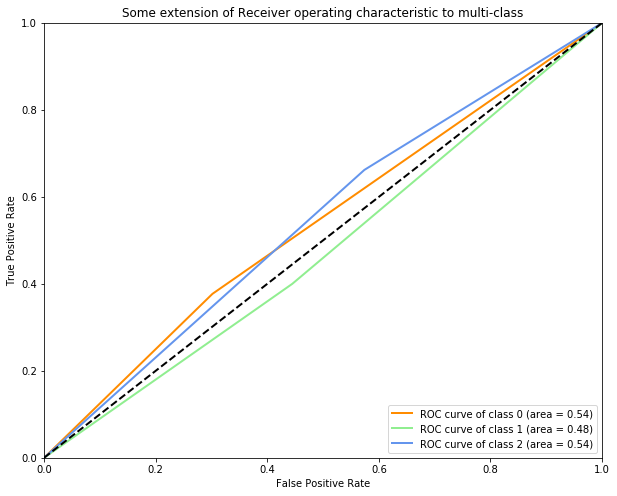

In [6]:
# 5 splits and shuffling
plot_roc_auc(classifier_list[0], 5)